# TikTok project: detect claims and opinions

This notebook includes all the end-of-course projects from the *Google Advanced Data Analytics certificate*. We emulate a real-world scenario where a data scientist from a company applies their knowledge to solve a technological challenge using statistics and machine learning.

## Background

Consider the following terms:
- a **claim** is something you propose to be true based on a certain argument or line of evidence. 
- an **opinion** is something you believe innately and is necessarily not open to proof or disproof. 

With this in mind, TikTok users have the ability to submit reports that identify videos and comments that contain user claims. These reports identify content that needs to be reviewed by moderators. The process generates a large number of user reports that are challenging to consider in a timely manner. 

TikTok is working on the development of **a predictive model that can determine whether a video contains a claim or offers an opinion**. With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently.

## Imports

In [1]:
# Handling data
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Stats
from scipy import stats

# data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample

# Data modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Graphical options
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

## Data inspection

First, we perform a data inspection, where we load the dataset and get basic information from it, such as the shape, the columns, the data types and summary statistics. The objetive of this stage is to get insights about the data before performing exploratory data analysis (EDA).

### General exploration

In [3]:
# Load dataset
data = pd.read_csv(filepath_or_buffer="dataset.csv", index_col=0)

In [4]:
# Get dataset shape
data.shape

(19382, 11)

In [5]:
# Inspect dataset
data.head(n=5)

,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
#,,,,,,,,,,,
1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


**The dataset stores 11 features (columns) regarding a sample of 19382 videos (rows).** The columns hold the following information:
- *claim_status* - label of associated to the video (claim or opinion).
- *video_id* - numerical id for the video.
- *video_duration_sec* - video duration in seconds.
- *video_transcription_text* - video transcription.
- *verified_status* - verification status of the user who posted the video.
- *author_ban_status* - ban status of the user who posted the video.
- *video_view_count* - number of video views.
- *video_like_count* - number of video likes.
- *video_share_count* - number of video shares.
- *video_download_count* - number of video downloads.
- *video_comment_count* - number of video comments.

In [6]:
# Explore data types
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19382 entries, 1 to 19382
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   claim_status              19084 non-null  object 
 1   video_id                  19382 non-null  int64  
 2   video_duration_sec        19382 non-null  int64  
 3   video_transcription_text  19084 non-null  object 
 4   verified_status           19382 non-null  object 
 5   author_ban_status         19382 non-null  object 
 6   video_view_count          19084 non-null  float64
 7   video_like_count          19084 non-null  float64
 8   video_share_count         19084 non-null  float64
 9   video_download_count      19084 non-null  float64
 10  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(2), object(4)
memory usage: 1.8+ MB


From the summary above, we can extract two conclusions:

- The columns which refer to engagement variables (views, likes, shares, downloads and comments), the video duration and the id are all numerical (int or float). The rest of the columns are objects (strings).

- Since the number of rows in the dataset is 19382, the following columns **present null or missing values**:  claim_status, video_transcription_text, views, likes, shares, downloads and comments.

In [7]:
# Print a summary of descriptive statistics
data.describe()

,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


The statistical summary suggests **there may be a number of outliers** in certain columns since their max and min values are much higher and smaller than their mean (i.e. the mean like count is ~84304, while the min and max values in its distribution are 0 and 657839, respectively).

### Target variable
Next, since claim_status is the target variable (the column we will try to predict using a machine learning model), let us explore the balance of the dataset (the number of rows which corresponds to each possible value of this column).

In [8]:
# Inspect dataset balance
pd.DataFrame(data['claim_status'].value_counts())

,claim_status
claim,9608
opinion,9476


The dataset is very balanced, since the two classes have a similar number of samples:
- **claims**: 9608 videos.
- **opinions**: 9476 videos.

### Engagement variables
<a id='engagement-variables'></a>

First, explore the engagement variables for the two types of videos: claims and opinions.

In [9]:
# Group data by claim status
data.groupby(['claim_status']).agg({
    'video_view_count'    : ['mean', 'median'],
    'video_like_count'    : ['mean', 'median'],
    'video_share_count'   : ['mean', 'median'],
    'video_comment_count' : ['mean', 'median'],
    'video_download_count': ['mean', 'median']
})

video_view_count           video_like_count            \
                         mean    median             mean    median   
claim_status                                                         
claim           501029.452748  501555.0    166373.331182  123649.0   
opinion           4956.432250    4953.0      1092.729844     823.0   

             video_share_count          video_comment_count         \
                          mean   median                mean median   
claim_status                                                         
claim             33026.416216  17997.5          691.164863  286.0   
opinion             217.145631    121.0            2.697446    1.0   

             video_download_count          
                             mean  median  
claim_status                               
claim                 2070.952227  1139.5  
opinion                 13.677290     7.0

The central tendency metrics displayed above suggest that the **videos labeled as claims have much more engagement compared to those labeled as opinions** (i.e. the mean view count for claims is ~501029 and for opinions is 4956, which is 100 times more).

Subsequently, explore the engagement variables for the different types of user statuses.

In [10]:
# Group data by user status
data.groupby(['author_ban_status']).agg({
    'video_view_count'    : ['mean', 'median'],
    'video_like_count'    : ['mean', 'median'],
    'video_share_count'   : ['mean', 'median'],
    'video_comment_count' : ['mean', 'median'],
    'video_download_count': ['mean', 'median']
})

video_view_count           video_like_count            \
                              mean    median             mean    median   
author_ban_status                                                         
active               215927.039524    8616.0     71036.533836    2222.0   
banned               445845.439144  448201.0    153017.236697  105573.0   
under review         392204.836399  365245.5    128718.050339   71204.5   

                  video_share_count          video_comment_count         \
                               mean   median                mean median   
author_ban_status                                                         
active                 14111.466164    437.0          295.134499    5.0   
banned                 29998.942508  14468.0          614.956575  209.0   
under review           25774.696999   9444.0          542.480639  136.5   

                  video_download_count         
                                  mean median  
author_ban_status                              
active                      882.276344   28.0  
banned                     1886.296024  892.0  
under review               1631.734753  610.5

The central tendency metrics displayed above suggest that the **videos from banned users have more engagement**, followed by those from under review users and active users.

### New variables

Here, we will create new variables by calculating the engagement variables per view. This will allow us to better interpret and compare engagement trends in the dataset.

In [11]:
# Calculate new engagement variables
for metric in ['like', 'comment', 'share']:
    col     = 'video_' + metric + '_count'
    col_new = metric + 's_per_view'
    data[col_new] = data[col] / data['video_view_count']

After creating the new engagement variables, let us explore their central tendency metrics for the different types of videos and user statuses.

In [12]:
# Group new engagement variables by claim and author status
data.groupby(['claim_status', 'author_ban_status']).agg({
    'likes_per_view'   : ['mean', 'median'],
    'comments_per_view': ['mean', 'median'],
    'shares_per_view'  : ['mean', 'median']
})

likes_per_view           comments_per_view  \
                                         mean    median              mean   
claim_status author_ban_status                                              
claim        active                  0.329542  0.326538          0.001393   
             banned                  0.345071  0.358909          0.001377   
             under review            0.327997  0.320867          0.001367   
opinion      active                  0.219744  0.218330          0.000517   
             banned                  0.206868  0.198483          0.000434   
             under review            0.226394  0.228051          0.000536   

                                         shares_per_view            
                                  median            mean    median  
claim_status author_ban_status                                      
claim        active             0.000776        0.065456  0.049279  
             banned             0.000746        0.067893  0.051606  
             under review       0.000789        0.065733  0.049967  
opinion      active             0.000252        0.043729  0.032405  
             banned             0.000193        0.040531  0.030728  
             under review       0.000293        0.044472  0.035027

From the data displayed above, we suggest the following **conclusions**:
- Claim videos seem to have higher engagement for the three user statuses.
- For claim videos, active and under review users seem to have less engagement than banned users.
- For opinion videos, active and under review users seem to have more engagement than banned users.

Finally, let us inspect the number of users types associated to the two video types.

In [13]:
# Count user types by video claim status
data.groupby(['claim_status', 'author_ban_status'])['video_id'].count().reset_index().rename(columns={'video_id': 'count'})

,claim_status,author_ban_status,count
0,claim,active,6566
1,claim,banned,1439
2,claim,under review,1603
3,opinion,active,8817
4,opinion,banned,196
5,opinion,under review,463


According to the data above, active users are evenly distributed among claims and opinions (6566 vs 8817), while **banned users are mainly grouped in the claim videos** (1439 vs 196). The distribution of the users under review ressembles the one for banned users (1603 vs 463).

## Exploratory data analysis (EDA)

EDA includes six steps (not all of them are always applicable, though). These steps are executed in the order needed for each specific project. Furthermore, some of the steps are often executed more than once.

1. *Discovering* - check out the overall shape, size, and content of the dataset.
2. *Cleaning* - check for outliers, missing data, and needs for conversions or transformations. 
3. *Structuring* -  structure the data in different time periods and segments to understand trends. 
4. *Joining* - add more data from other datasets.
5. *Validating* - double check the changes you made are correct and accurate. 
6. *Presenting* - share your dataset with a peer. 



In the previous section, we performed a preliminary data inspection, which corresponds to the first step of EDA (*Discovering*). In this stage, we will apply other steps of the EDA to: fill the missing values in the dataset, explore the relationships between the variables (columns) and their distributions and perform statistical analyses.

### Distribution of engagement variables
<a id='distribution_of_engagement_variables'></a>

First, we will explore the distribution of *video_duration_sec* to analyze the duration of the videos uploaded to the platform.


<Axes: xlabel='video_duration_sec', ylabel='Count'>

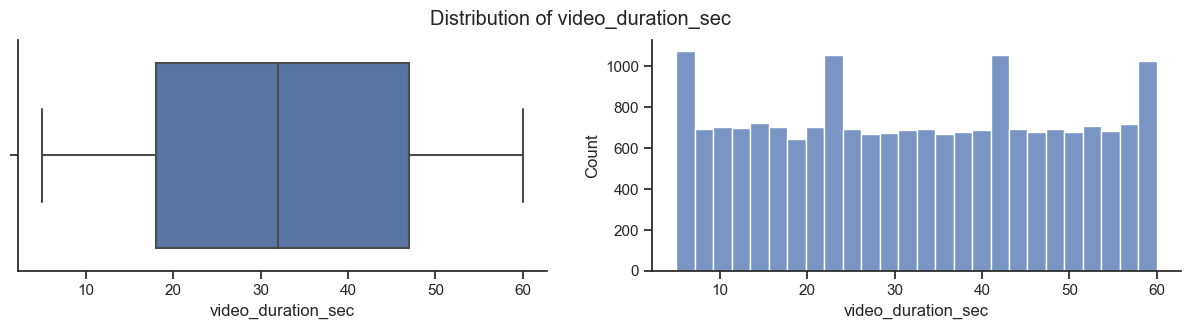

In [14]:
# Plot a boxplot and a histogram to explore the distribution of video_duration_sec
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 3))
fig.suptitle(f'Distribution of video_duration_sec')
sns.boxplot(data=data, x='video_duration_sec', ax=axes[0])
sns.histplot(data=data, x='video_duration_sec', ax=axes[1])

According to the plots above, **the distribution of the video duration is close to uniform**, with a median ~30 seconds and maximum and minimum values close or equal to 60 seconds and 0 seconds, respectively.

Next, we will explore the distributions of the engagement variables using the same kind of plots.

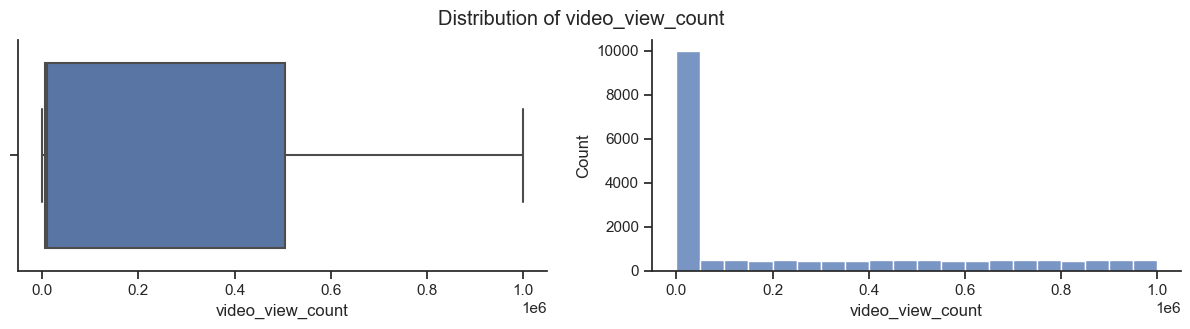

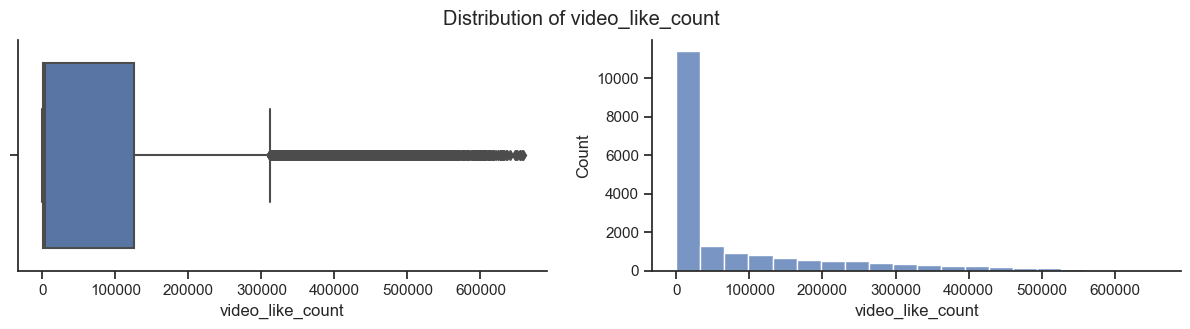

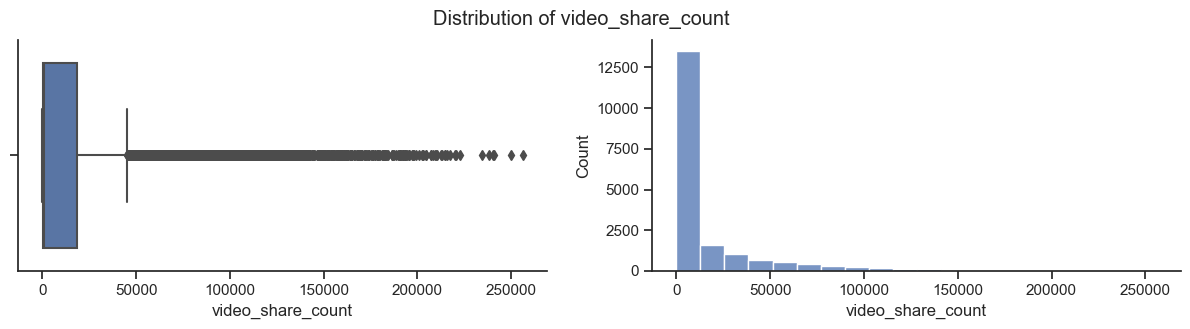

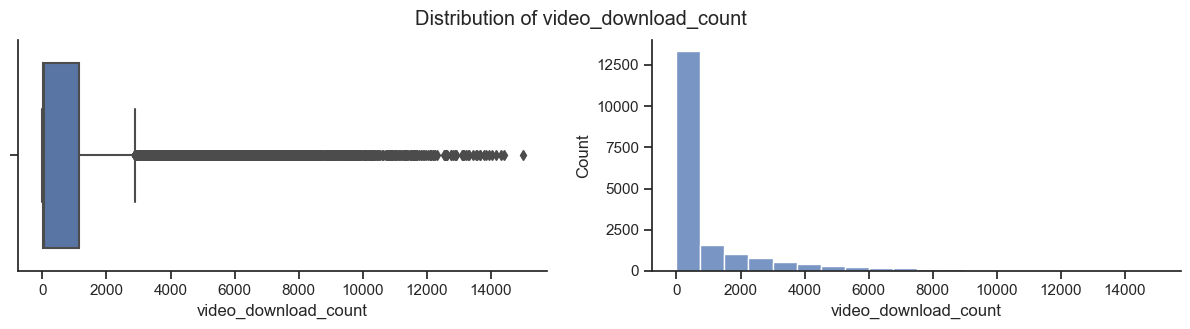

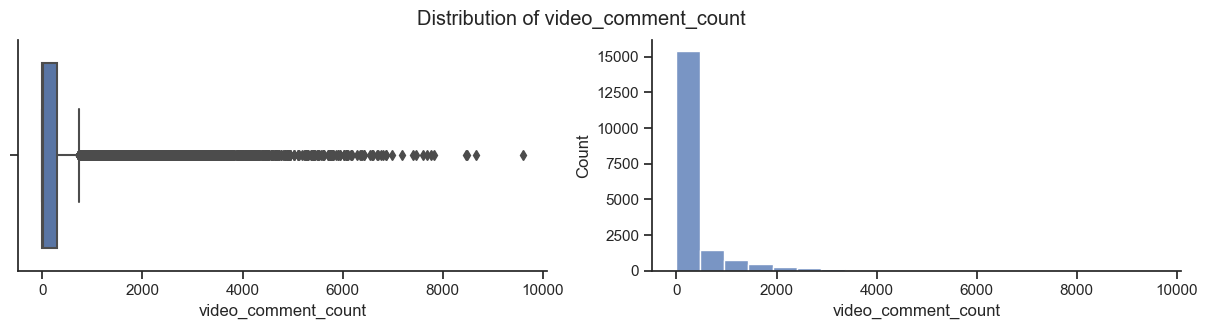

In [15]:
# Plot a boxplot and a histogram to explore the distribution of the engagement variables
for col in ['video_' + x + '_count' for x in ['view', 'like', 'share', 'download', 'comment']]:
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 3))
    fig.suptitle(f'Distribution of {col}')
    sns.boxplot(data=data, x=col, ax=axes[0])
    sns.histplot(data=data, x=col, bins=20, ax=axes[1])

Considering the histograms shown in the right column, the distributions of the engagement variables are all skewed to the right, with most datapoints grouped around a reduced value for all the engagement variables. Then, from the lower to a higher values of the variables, the distribution is uniform.

This means **most part of the videos show a reduced engagement level (views, likes, comments, etc.) while a reduced group of videos shows a extremely high engagement level (viral videos)**. This is also notable from the boxplots displayed in the left column, where the number of outliers to the right of the distribution is easily noticeable. 

### Count of verified and ban statuses by claim status

Here, let us calculate the count of claim and opinion videos with respect to:
- the verification status of the videos (*verified_status*).
- the author ban status (*author_ban_status*).

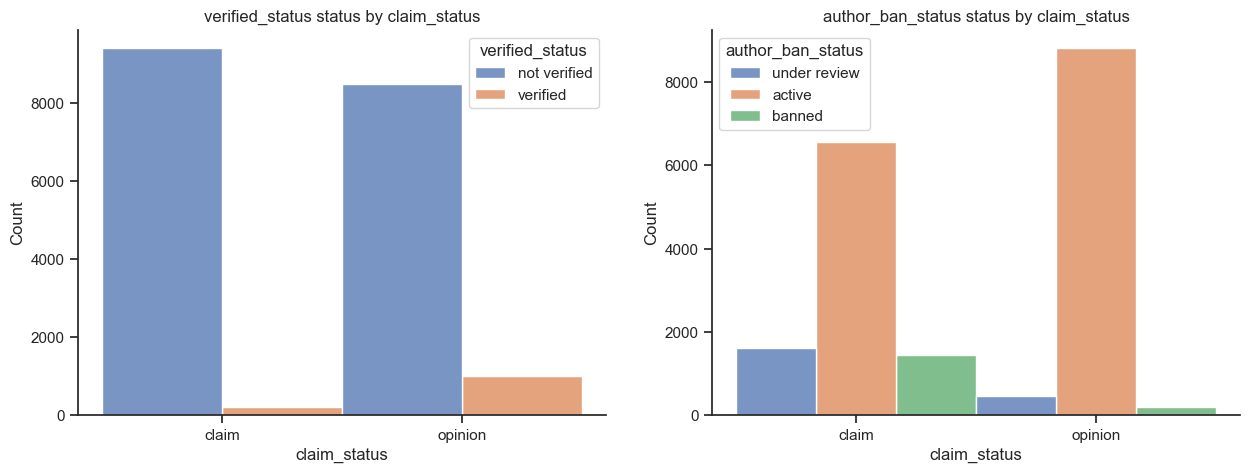

In [16]:
# Select the variables to explore
cols = ['verified_status', 'author_ban_status']

# Create figures
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for col, axs in zip(cols, axes):
    axs.set_title(f'{col} status by claim_status')
    sns.histplot(data=data, x='claim_status', hue=col, multiple='dodge', ax=axs)

From the left plot we can derive two conclusions:
1. **There are many more not verified than verified users** for both kinds of videos (claims and opinions).
2. **When the users are verified, they tend to post many more opinion videos** than claim videos.

From the right plot we can derive another two conclusions:
1. Users **banned and under review seem to post more claim videos** than opinions.
2. **Active users seem to post both claims and opinions**, being opinions a bit more common than claims.

### Median view counts by ban status

In this subsection, we group the data by ban status and plot the median video view count per group.

<Axes: xlabel='author_ban_status', ylabel='median_view_count'>

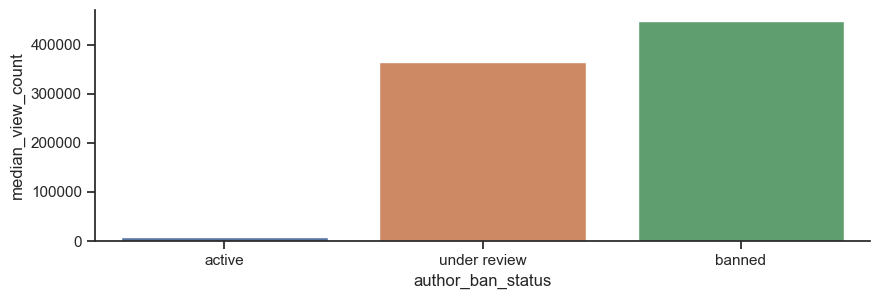

In [17]:
# Group data by ban status
data_by_ban = data.groupby('author_ban_status').median(numeric_only=True)['video_view_count']
data_by_ban = data_by_ban.reset_index()
data_by_ban = data_by_ban.rename(columns={'video_view_count': 'median_view_count'})

# Create bar plot
plt.figure(figsize=(10, 3))
sns.barplot(data=data_by_ban, x='author_ban_status', y='median_view_count', order=['active', 'under review', 'banned'])

As pointed out in the subsection [Engagement variables](#engagement-variables), the median view count for under review and banned users is much higher compared to active users. Furthermore, since in the previous plot we discovered that active users are more likely to post opinions, we can hypothize that: videos with a high number of views are more likely to be claims. **Therefore, the view count may be indicative of the claim status**.

### Detect outliers
<a id='detect_outliers'></a>

When building predictive models, the presence of outliers can be problematic. For example, if you were trying to predict the view count of a particular video, videos with extremely high view counts might introduce bias to a model. Also, some outliers might indicate problems with how data was captured or recorded.

The analysis performed so far indicates that a video's engagement level is strongly correlated with its claim status. There's no reason to believe that any of the values in the TikTok data are erroneously captured, and they align with expectation of how social media works: a very small proportion of videos get super high engagement levels. That's the nature of viral content.

In this TikTok dataset, the values for the count variables are not normally distributed. They are heavily skewed to the right. **A way of modifying the outlier threshold is by calculating the median value for each variable and then adding 1.5 * IQR**. This results in a threshold that is, in this case, much lower than it would be if the 3rd quartile was used.

In [18]:
# Estimate the number of outliers per variable
for col in ['video_' + metric + '_count' for metric in ['view', 'like', 'share', 'download', 'comment']]:
    iqr    = data[col].quantile(0.75) - data[col].quantile(0.25)
    median = data[col].median()
    thr    = median + 1.5 * iqr
    outlier_percent = round(sum(data[col] > thr) / sum(~data[col].isna()) * 100, 2)
    print(f'# Outliers for {col}: {sum(data[col] > thr)} ({outlier_percent}% of the samples)')

# Outliers for video_view_count: 2343 (12.28% of the samples)
# Outliers for video_like_count: 3468 (18.17% of the samples)
# Outliers for video_share_count: 3732 (19.56% of the samples)
# Outliers for video_download_count: 3733 (19.56% of the samples)
# Outliers for video_comment_count: 3882 (20.34% of the samples)


For the engagement variables, **the outliers represent ~20% of the total number of samples.**

### Hypothesis testing 

Let us consider we are interested in investigating if there is a statistical significant difference between the mean video view count for verified and not verified users. The first step would be to estimate a descriptive statistic (the mean, in this case) and state the null and alternative hypothesis.

In [19]:
# Estimate the mean video_view_count per verified_status
data.groupby('verified_status').agg({'video_view_count': ['count', 'mean']}).rename(columns={'video_view_count': 'mean_video_view_count'})

mean_video_view_count               
                                count           mean
verified_status                                     
not verified                    17884  265663.785339
verified                         1200   91439.164167

According to the table displayed above, the mean video view count is higher for not verified users than for verified users. However, a hypothesis test is required to determine if the difference is statistically significant.

Since the null hypothesis always attributes the differences observed in the sample statistics to chance or sample variability, we can define the following two hypothesis:

$H_{0}$: $\mu_{verified} = \mu_{not verified}$ - There is no difference in number of views between TikTok videos posted by verified accounts and TikTok videos posted by unverified accounts (any observed difference in the sample data is due to chance or sampling variability).

$H_{A}$: $\mu_{verified} \neq \mu_{not verified}$ - There is a difference in number of views between TikTok videos posted by verified accounts and TikTok videos posted by unverified accounts (any observed difference in the sample data is due to an actual difference in the corresponding population means).

In [20]:
# Run an independent two-sample t-test with a two-sided alternative hypothesis
stats.ttest_ind(
    a=data[data['verified_status'] == 'verified']['video_view_count'],
    b=data[data['verified_status'] == 'not verified']['video_view_count'],
    equal_var=False,
    alternative='two-sided',
    nan_policy='omit'
)

Ttest_indResult(statistic=-25.499441780633777, pvalue=2.608882368718078e-120)

The p-value is 2.60e-120, which is much smaller than the usual significance level of 0.05 (p-value < 0.05). Considering this, **we can reject the null hypothesis, and state that there is a statistically significant difference between mean video view count from verified and not verified users.**

In conclusions, there is statistical evidence which suggest not verified users obtain higher video view counts in their videos compared to verified users. The company should **investigate the reasons behind this**. Maybe not verified users tend to use bots to generate viral videos or they create more click-bait videos compared to verified users.

To analyze the behavior of the verified and not verified users, the next step could be to **implement a logistic regression model to predict wether videos are claims or opinions**. During this procedure, we must keep in mind that the distributions of the engagement variables are skewed to the right and there is a significant difference between verified and not verified users.

## Logistic regression

The TikTok team has reviewed the results of the hypothesis testing. TikTok’s Operations Lead, Maika Abadi, is interested in how different variables are associated with whether a user is verified. Earlier, the data team observed that if a user is verified, they are much more likely to post opinions. 

Now, the data team has decided to explore **how to predict *verified_status* to help them understand how video characteristics relate to verified users**. Therefore, you have been asked to conduct a logistic regression using verified status as the outcome variable. The results may be used to inform the final model related to predicting whether a video is a claim vs an opinion.

### EDA for logistic regression

How can EDA help throughout a regression analysis? EDA is used to clean the data, for example by dropping the missing values which cannot be used by this model or by transforming categorial variables into numerical ones, since this model cannot used categorical independent variables.

#### Missing values
Missing values cannot be handle by logistic regression. Thus, we need to identify them and remove them from the dataset.

In [21]:
# Calculate the number of missing values per column
missing_per_col = sum(data.isna().values).tolist()
for idx, col in enumerate(data.columns):
    print(f'Missing values in column {col}: {missing_per_col[idx]}')

Missing values in column claim_status: 298
Missing values in column video_id: 0
Missing values in column video_duration_sec: 0
Missing values in column video_transcription_text: 298
Missing values in column verified_status: 0
Missing values in column author_ban_status: 0
Missing values in column video_view_count: 298
Missing values in column video_like_count: 298
Missing values in column video_share_count: 298
Missing values in column video_download_count: 298
Missing values in column video_comment_count: 298
Missing values in column likes_per_view: 298
Missing values in column comments_per_view: 298
Missing values in column shares_per_view: 298


In [22]:
# Drop the rows containing missing values
data.dropna(axis=0, inplace=True)

# Validate the drop
missing_per_col = sum(data.isna().values).tolist()
for idx, col in enumerate(data.columns):
    print(f'Missing values in column {col}: {missing_per_col[idx]}')

Missing values in column claim_status: 0
Missing values in column video_id: 0
Missing values in column video_duration_sec: 0
Missing values in column video_transcription_text: 0
Missing values in column verified_status: 0
Missing values in column author_ban_status: 0
Missing values in column video_view_count: 0
Missing values in column video_like_count: 0
Missing values in column video_share_count: 0
Missing values in column video_download_count: 0
Missing values in column video_comment_count: 0
Missing values in column likes_per_view: 0
Missing values in column comments_per_view: 0
Missing values in column shares_per_view: 0


#### Duplicates
Check for duplicate observations and removed them in case.

In [23]:
# Check for duplicate observations (rows)
print(f'The number of duplicated rows is: {sum(data.duplicated())}')

The number of duplicated rows is: 0


#### Outliers
Like we discovered in subsection [Detect outliers](#detect_outliers), approximately 20% of the values of the engagement variable distributions correspond to outliers. For this regression analysis, let us clip those outliers to the maximum upper threshold of P(75) + 1.5 · IQR.

In [24]:
# Winsorize the engagement variables for regression analysis
for col in ['video_like_count', 'video_comment_count']:
    iqr    = data[col].quantile(0.75) - data[col].quantile(0.25)
    thr    = data[col].quantile(0.75) + 1.5 * iqr
    data.loc[data[col] > thr, col] = thr

<span style='color:red; font-weight: bold'>Note:</span><br>
In the previous cell, we only winsorized the like and comment counts as suggested by the course instructors. Based on the boxplots displayed in previous sections, I would also winsorize downloads and shares, but I did not do this in order to keep the results consistent with those provided in the course.

#### Class balance
Since we are interested in the outcome variable *verified_status*, let us inspect how balanced is the dataset in regards to this variable

In [25]:
data['verified_status'].value_counts(normalize=True)

not verified    0.93712
verified        0.06288
Name: verified_status, dtype: float64

The data is very unbalanced towards the *not_verified* class. Therefore, let us resample the minority class (*verified*) to produce the same number of samples than the majority class (*not_verified*).

In [26]:
# Identify data points from majority and minority classes
majority = data.loc[data['verified_status'] == 'not verified', :]
minority = data.loc[data['verified_status'] != 'not verified', :]

# Upsample the minority class
minority_upsampled = resample(minority, n_samples=len(majority), random_state=0)

# Combine majority class with upsampled minority class
data_upsampled = pd.concat([majority, minority_upsampled], axis=0).reset_index(drop=True)

# Display new class counts
data_upsampled['verified_status'].value_counts()

not verified    17884
verified        17884
Name: verified_status, dtype: int64

#### Create new variable
Extract the length of each video_transcription_text and add this as a column to the dataframe, so that it can be used as a potential feature in the model.

In [27]:
data_upsampled['transcription_len'] = data_upsampled['video_transcription_text'].apply(lambda x: len(x))

Visualize the distribution of *video_transcription_text* length for videos posted by verified accounts and videos posted by unverified accounts.

Text(0.5, 1.0, 'Not verified users')

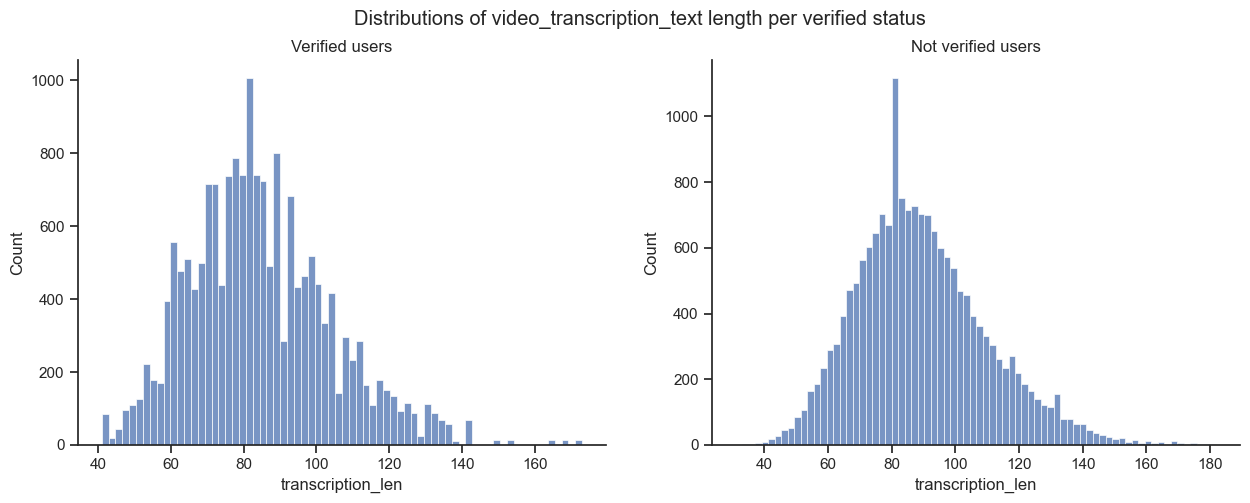

In [28]:
# Create figure
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Histograms
sns.histplot(data=data_upsampled[data_upsampled['verified_status']=='verified'], x='transcription_len', ax=ax[0])
sns.histplot(data=data_upsampled[data_upsampled['verified_status']!='verified'], x='transcription_len', ax=ax[1])

# Style
fig.suptitle('Distributions of video_transcription_text length per verified status')
ax[0].set_title('Verified users')
ax[1].set_title('Not verified users')

#### Multicolinearity
Next, we evaluate the multicolinearity between the independent variables considered for the regression problem. To do so, we will calculate the correlation matrix and plot it using a heatmap.

<Axes: >

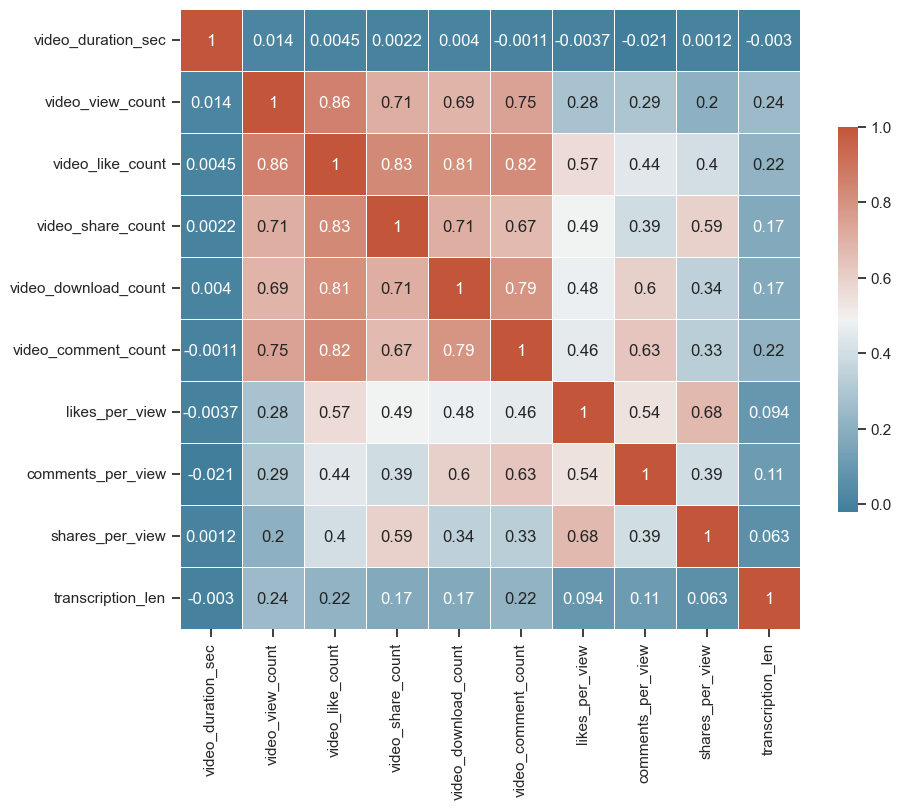

In [29]:
# Compute the correlation matrix
corr = data_upsampled[[col for col in data_upsampled.columns if col != 'video_id']].corr(numeric_only=True)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Considering a high correlation threshold of 0.85, there are two variables which show multicolinearity: *video_like_count* with *video_view_count* (0.86). Therefore, in order not to violate this model assumption, we can get rid of *video_like_count*.

### Logistic regression model
In this stage, we will prepare the training and test sets. For the feature matrix, we will select only those variables which can provide insights about the outcome variable. We will need to transform the categorical variables (the independent variables *claim_status* and *author_ban_status* and the outcome variable *verified_status*) in the dataset into numerical. To do so, we will use one-hot encoding. 

In [30]:
# Select features
X = data_upsampled[['video_duration_sec', 'claim_status', 'author_ban_status', 'video_view_count', 'video_share_count', 'video_download_count', 'video_comment_count']]

# Select outcome variable
y = data_upsampled[['verified_status']]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

<span style='color:red; font-weight: bold'>Note:</span><br>
In the previous cell we only considered only a subset of the original features included in the dataset. Other variables, likes the engagement variables per view created in previous sections were not considered. We proceded this way to be consistent with the course instructors, who considered only the set of features shown above for variable X.

Encode the categorical variables in the training set

In [31]:
# Encode categorical variables in the training set using one-hot encoding
X_encoder          = OneHotEncoder(drop='first', sparse_output=False)
X_train_encoded    = X_encoder.fit_transform(X_train[['claim_status', 'author_ban_status']])
X_train_encoded_df = pd.DataFrame(data=X_train_encoded, columns=X_encoder.get_feature_names_out())

# Drop categorical variables from the training set 
X_train_numerical = X_train[[col for col in X_train.columns if col not in ['claim_status', 'author_ban_status']]]
X_train_numerical.reset_index(drop=True, inplace=True)

# Concatenate the encoded variables to the training set
X_train_final = pd.concat([X_train_numerical, X_train_encoded_df], axis=1)

# Encode the outcome variable in the training set
y_train_encoder = OneHotEncoder(drop='first', sparse_output=False)
y_train_final   = y_train_encoder.fit_transform(y_train).ravel()

Encode the categorical variables in the test set (using the encoders fitted on the training set).

In [32]:
# Encode categorical variables in the test set using one-hot encoding
X_test_encoded    = X_encoder.transform(X_test[['claim_status', 'author_ban_status']])
X_test_encoded_df = pd.DataFrame(data=X_test_encoded, columns=X_encoder.get_feature_names_out())

# Drop categorical variables from the test set 
X_test_numerical = X_test[[col for col in X_train.columns if col not in ['claim_status', 'author_ban_status']]]
X_test_numerical.reset_index(drop=True, inplace=True)

# Concatenate the encoded variables to the test set
X_test_final = pd.concat([X_test_numerical, X_test_encoded_df], axis=1)

# Encode the outcome variable in the test set
y_test_final = y_train_encoder.transform(y_test).ravel()

Create a logistic regression model, fit the model using the training set, estimate the predictions for the test set and evaluate the model performance using a confusion matrix.

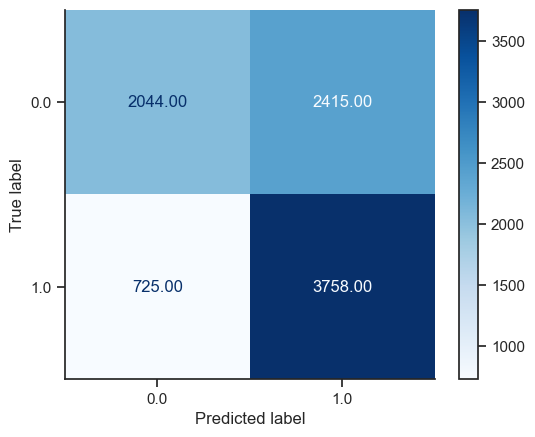

In [33]:
# Create and fit the model
clf = LogisticRegression(max_iter=1000, random_state=0).fit(X_train_final, y_train_final)

# Get test set predictions
y_pred = clf.predict(X_test_final).ravel()

# Compute values for confusion matrix
cm = confusion_matrix(y_test_final, y_pred, labels=clf.classes_)

# Create display of confusion matrix
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

# Plot confusion matrix
cm_disp.plot(values_format='.2f', cmap='Blues')

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the logistic regression model.

In [34]:
# Create a classification report
print(classification_report(y_test_final, y_pred, target_names=['verified', 'not verified']))

              precision    recall  f1-score   support

    verified       0.74      0.46      0.57      4459
not verified       0.61      0.84      0.71      4483

    accuracy                           0.65      8942
   macro avg       0.67      0.65      0.64      8942
weighted avg       0.67      0.65      0.64      8942



Finally, we will inspect the coefficients produced by the logistic regression for each of the independent variables considered in the model.

In [35]:
# Create a dataframe with the coefficients
pd.DataFrame(data={'Feature Name': X_train_final.columns.tolist(), 'Model Coefficient': clf.coef_[0]})

,Feature Name,Model Coefficient
0,video_duration_sec,8.607893e-03
1,video_view_count,-2.132079e-06
2,video_share_count,5.930971e-06
3,video_download_count,-1.099775e-05
4,video_comment_count,-6.404235e-04
5,claim_status_opinion,3.908384e-04
6,author_ban_status_banned,-1.781741e-05
7,author_ban_status_under review,-9.682447e-07


From this section, we can extract two main conclusions regarding the modeling of the variable *verified_status*:
1. From the coefficients of the logistic regression model: the video duration and the comment count are the two variables which most influence the outcome variable. Every second of the video duration increase the log odds of the probability of an user being verified by 0.009 (considering the rest of the independent variables are held constant). Therefore, **longer videos tend to be associated with higher odds of the user being verified**. In the case of the comment count, each additional comment reduces the former log odds by 0.0004.
<br>

2. The logistic regression models predicts the outcome variable *verified_status* with **higher accuracy than random choice** (0.65 vs 0.5). The macro average precision and recall metrics obtained from the test set evaluation are 0.67 and 0.65, respectively.
<br>